In [ ]:
try:
  import torch_geometric
except:
  !pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
  !pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
  !pip install torch-geometric

### Data loading

In [ ]:
from torch_geometric.data import download_url, extract_zip

url = 'https://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
extract_zip(download_url(url, '.'), '.')

movie_path = './ml-latest-small/movies.csv'
rating_path = './ml-latest-small/ratings.csv'

Using existing file ml-latest-small.zip
Extracting ./ml-latest-small.zip


In [ ]:
import pandas as pd

ratings = pd.read_csv(rating_path)
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


(array([ 1370.,  2811.,  1791.,  7551.,  5550., 20047., 13136., 26818.,
         8551., 13211.]),
 array([0.5 , 0.95, 1.4 , 1.85, 2.3 , 2.75, 3.2 , 3.65, 4.1 , 4.55, 5.  ]),
 <a list of 10 Patch objects>)

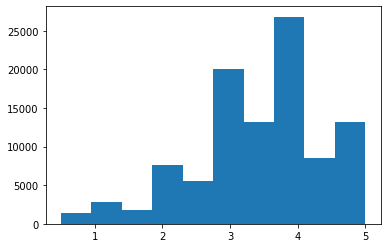

In [ ]:
# ratings distribution
import matplotlib.pyplot as plt
plt.hist(ratings['rating'])

In [ ]:
# nodes
import torch 
user_mapping = {user_id: index for index, user_id in enumerate(ratings['userId'].unique())}
num_users = len(user_mapping)
movie_mapping = {movie_id: index + num_users for index, movie_id in enumerate(ratings['movieId'].unique())}
num_movies = len(movie_mapping)

num_nodes = num_users + num_movies
x = torch.range(0, num_nodes - 1)[:, None]
x = x.type(torch.int)
print(x)
print(x.shape)
print(x.dtype)

tensor([[    0],
        [    1],
        [    2],
        ...,
        [10331],
        [10332],
        [10333]], dtype=torch.int32)
torch.Size([10334, 1])
torch.int32


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  if __name__ == '__main__':


In [ ]:
# edges index
src = [user_mapping[index] for index in ratings['userId']]
dst = [movie_mapping[index] for index in ratings['movieId']]
edge_index = torch.tensor([src, dst])
print(edge_index)
print(edge_index.shape)
print(edge_index.dtype)

tensor([[   0,    0,    0,  ...,  609,  609,  609],
        [ 610,  611,  612,  ..., 3731, 2002, 3483]])
torch.Size([2, 100836])
torch.int64


In [ ]:
# edges label
edge_label = torch.tensor(ratings['rating'][:, None], dtype=torch.float)
print(edge_label)
print(edge_label.shape)
print(edge_label.dtype)

tensor([[4.],
        [4.],
        [4.],
        ...,
        [5.],
        [5.],
        [3.]])
torch.Size([100836, 1])
torch.float32


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


In [ ]:
from torch_geometric.data import Data

data = Data(x=x, edge_index=edge_index, edge_label=edge_label)
print(data)

Data(x=[10334, 1], edge_index=[2, 100836], edge_label=[100836, 1])


### Training

In [ ]:
import torch
import torch.nn.functional as F

from torch_geometric.nn import GCNConv

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.embed = torch.nn.Embedding(num_nodes, 16)
        self.conv1 = GCNConv(16, 16)
        self.conv2 = GCNConv(16, 16)
        self.fc1 = torch.nn.Linear(32, 1)

    def encode(self):
        x = self.embed(data.x)
        x = x.squeeze()
        x = self.conv1(x, data.edge_index) # convolution 1
        x = x.relu()
        return self.conv2(x, data.edge_index) # convolution 2

    def decode(self, z): 
        z = torch.concat((z[data.edge_index[0]], z[data.edge_index[1]]), axis=-1)
        return self.fc1(z)

In [ ]:
model, data = Net().to(device), data.to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0005)

In [ ]:
def train():
    model.train()

    optimizer.zero_grad()
    z = model.encode() #encode
    z = model.decode(z) # decode
    loss = F.mse_loss(z, data.edge_label)
    loss.backward()
    optimizer.step()

    return loss

In [ ]:
for epoch in range(1, 10000):
    train_loss = train()
    log = 'Epoch: {:03d}, Loss: {:.4f}'
    if epoch % 500 == 0:
        print(log.format(epoch, train_loss))

Epoch: 500, Loss: 0.9758
Epoch: 1000, Loss: 0.7996
Epoch: 1500, Loss: 0.7553
Epoch: 2000, Loss: 0.7366
Epoch: 2500, Loss: 0.7232
Epoch: 3000, Loss: 0.7104
Epoch: 3500, Loss: 0.6951
Epoch: 4000, Loss: 0.6774
Epoch: 4500, Loss: 0.6660
Epoch: 5000, Loss: 0.6592
Epoch: 5500, Loss: 0.6535
Epoch: 6000, Loss: 0.6488
Epoch: 6500, Loss: 0.6450
Epoch: 7000, Loss: 0.6422
Epoch: 7500, Loss: 0.6392
Epoch: 8000, Loss: 0.6369
Epoch: 8500, Loss: 0.6350
Epoch: 9000, Loss: 0.6333
Epoch: 9500, Loss: 0.6318
